In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)

In [3]:
RAW_DATA_PATH = "C:/Users/addme/Downloads/CIS545_Project/income_database.csv"
PROCESSED_DIR = "C:/Users/addme/Downloads/CIS545_Project/Processed/"

In [4]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [5]:
def convert_income_range(x):
    """
    Convert income ranges like '$50,000 to $75,000' → midpoint value.
    If already numeric, return as is.
    """
    if pd.isna(x):
        return np.nan
    
    if isinstance(x, (int, float)):
        return x
    
    x = str(x).replace(",", "").replace("$", "").strip()

    # Cases like "50000-75000" or "50000 to 75000"
    if "to" in x:
        parts = x.split("to")
        low = float(parts[0].strip())
        high = float(parts[1].strip())
        return (low + high) / 2
    
    if "-" in x:
        parts = x.split("-")
        low = float(parts[0].strip())
        high = float(parts[1].strip())
        return (low + high) / 2

    # Single value
    try:
        return float(x)
    except:
        return np.nan

In [6]:
def normalize_numeric(df, cols):
    """
    Apply MinMax scaling to given numeric columns.
    """
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

In [7]:
def standardize_numeric(df, cols):
    """
    Apply StandardScaler (z-normalization) to given numeric columns.
    """
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

In [9]:
print("Loading dataset from:", RAW_DATA_PATH)

df = pd.read_csv(RAW_DATA_PATH, encoding="utf-8", encoding_errors="ignore")

print("✔ Dataset loaded successfully.")
print("Shape:", df.shape)

Loading dataset from: C:/Users/addme/Downloads/CIS545_Project/income_database.csv
✔ Dataset loaded successfully.
Shape: (325259, 19)


C:\Users\addme\AppData\Local\Temp\ipykernel_24512\3768109038.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATA_PATH, encoding="utf-8", encoding_errors="ignore")


In [11]:
df.head()

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638
1,1011001,1,Alabama,AL,Talladega County,Childersburg,Childersburg city,City,place,35044,256,31919335,652240,33.291877,-86.340599,39421,25400,43141,1642
2,1011002,1,Alabama,AL,Calhoun County,Anniston,Choccolocco,CDP,place,36207,256,30159923,239225,33.674346,-85.710918,73511,54847,62988,554
3,1011003,1,Alabama,AL,Mobile County,Wilmer,Chunchula,CDP,place,36587,251,4671130,21008,30.927194,-88.208200,34753,300000,28467,55
4,1011004,1,Alabama,AL,Mobile County,Citronelle,Citronelle city,City,place,36522,251,66930189,713078,31.097269,-88.249843,56102,48865,44810,892


In [12]:
# Handle missing values
print("\nMissing values BEFORE cleaning:")
print(df.isna().sum())


Missing values BEFORE cleaning:
id            0
State_Code    0
State_Name    0
State_ab      0
County        0
City          0
Place         0
Type          0
Primary       0
Zip_Code      0
Area_Code     0
ALand         0
AWater        0
Lat           0
Lon           0
Mean          0
Median        0
Stdev         0
sum_w         0
dtype: int64


In [13]:
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values AFTER cleaning:")
print(df.isna().sum())


Missing values AFTER cleaning:
id            0
State_Code    0
State_Name    0
State_ab      0
County        0
City          0
Place         0
Type          0
Primary       0
Zip_Code      0
Area_Code     0
ALand         0
AWater        0
Lat           0
Lon           0
Mean          0
Median        0
Stdev         0
sum_w         0
dtype: int64


In [17]:
# Normalize / Standardize numeric fields
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [18]:
print("Numeric columns:", numeric_cols)

Numeric columns: ['id', 'State_Code', 'Zip_Code', 'ALand', 'AWater', 'Lat', 'Lon', 'Mean', 'Median', 'Stdev', 'sum_w']


In [19]:
# Standardize
df_standardized = df.copy()
df_standardized = standardize_numeric(df_standardized, numeric_cols)

# Normalize
df_normalized = df.copy()
df_normalized = normalize_numeric(df_normalized, numeric_cols)

print("✔ Normalization and standardization completed.")

✔ Normalization and standardization completed.


In [22]:
# Aggregation: County-level summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# County-level aggregation using existing Mean, Median, Stdev
if "State_Name" in df.columns and "County" in df.columns:
    
    county_group = df.groupby(["State_Name", "County"]).agg({
        "Mean": "mean",
        "Median": "median",
        "Stdev": "mean",
        numeric_cols[0]: "count"
    })

    county_group.columns = ["MeanIncome", "MedianIncome", "StdIncome", "NumRecords"]
    county_group.reset_index(inplace=True)

    # Save
    county_group.to_csv(PROCESSED_DIR + "county_aggregates.csv", index=False)

    print("\n✔ County-level aggregation saved.")

else:
    print("⚠ County-level aggregation skipped: columns missing.")


✔ County-level aggregation saved.


In [23]:
# State-level aggregation using existing Mean/Median/Stdev
if "State_Name" in df.columns:

    state_group = df.groupby("State_Name").agg({
        "Mean": "mean",
        "Median": "median",
        "Stdev": "mean",
        numeric_cols[0]: "count"
    })

    state_group.columns = ["MeanIncome", "MedianIncome", "StdIncome", "NumRecords"]
    state_group.reset_index(inplace=True)

    # Save
    state_group.to_csv(PROCESSED_DIR + "state_aggregates.csv", index=False)

    print("✔ State-level aggregation saved.")

else:
    print("⚠ State-level aggregation skipped: 'State_Name' column missing.")

✔ State-level aggregation saved.


In [24]:
processed_path = PROCESSED_DIR + "income_cleaned.csv"
df.to_csv(processed_path, index=False)

print("\n✔ Processed dataset saved to:", processed_path)


✔ Processed dataset saved to: C:/Users/addme/Downloads/CIS545_Project/Processed/income_cleaned.csv


In [25]:
print("\n========== FINAL DATASET SHAPE ==========")
print(df.shape)


========== FINAL DATASET SHAPE ==========
(325259, 19)


In [26]:
print("\n========== HEAD ==========")
display(df.head())


========== HEAD ==========


,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638
1,1011001,1,Alabama,AL,Talladega County,Childersburg,Childersburg city,City,place,35044,256,31919335,652240,33.291877,-86.340599,39421,25400,43141,1642
2,1011002,1,Alabama,AL,Calhoun County,Anniston,Choccolocco,CDP,place,36207,256,30159923,239225,33.674346,-85.710918,73511,54847,62988,554
3,1011003,1,Alabama,AL,Mobile County,Wilmer,Chunchula,CDP,place,36587,251,4671130,21008,30.927194,-88.208200,34753,300000,28467,55
4,1011004,1,Alabama,AL,Mobile County,Citronelle,Citronelle city,City,place,36522,251,66930189,713078,31.097269,-88.249843,56102,48865,44810,892


In [27]:
print("\n========== SUMMARY STATISTICS ==========")
display(df.describe(include="all"))


========== SUMMARY STATISTICS ==========


,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
count,3.252590e+05,325259.000000,325259,325259,325259,325259,325259,325259,325259,325259.000000,325259.0,3.252590e+05,3.252590e+05,325259.000000,325259.000000,325259.000000,325259.000000,325259.000000,325259.000000
unique,NaN,NaN,52,52,1957,12234,22049,14,2,NaN,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,California,CA,Adams County,Chicago,Alameda city,Track,Track,NaN,718.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32795,32795,67086,2985,31270,294334,294334,NaN,7072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.204941e+07,28.625379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50181.297621,NaN,1.158351e+08,7.178237e+06,37.729045,-91.303675,67006.326122,86242.539874,47431.387101,575.539453
std,1.115724e+08,16.296817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29412.133123,NaN,1.331131e+09,2.020345e+08,5.573090,16.241299,30521.748941,88351.861999,16607.294183,3439.233462
min,1.021000e+03,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,601.000000,NaN,0.000000e+00,0.000000e+00,17.901633,-176.566001,0.000000,0.000000,0.000000,0.000000
25%,8.021282e+06,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26419.000000,NaN,1.900520e+06,0.000000e+00,34.011687,-97.677462,46172.500000,36115.000000,36137.000000,202.000000
50%,2.901169e+07,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48161.000000,NaN,5.085422e+06,2.743900e+04,38.922334,-87.119592,61087.000000,52164.000000,46331.000000,328.000000
75%,4.802899e+07,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76708.000000,NaN,3.140103e+07,5.212210e+05,41.489825,-79.851841,82410.000000,81845.000000,58317.000000,588.000000


In [28]:
print("Exploratory Data Analysis (EDA)")

# Quick reminder of columns
print("\nColumns in df:")
print(df.columns.tolist())

Exploratory Data Analysis (EDA)

Columns in df:
['id', 'State_Code', 'State_Name', 'State_ab', 'County', 'City', 'Place', 'Type', 'Primary', 'Zip_Code', 'Area_Code', 'ALand', 'AWater', 'Lat', 'Lon', 'Mean', 'Median', 'Stdev', 'sum_w']



Income-related columns found: ['Mean', 'Median', 'Stdev']


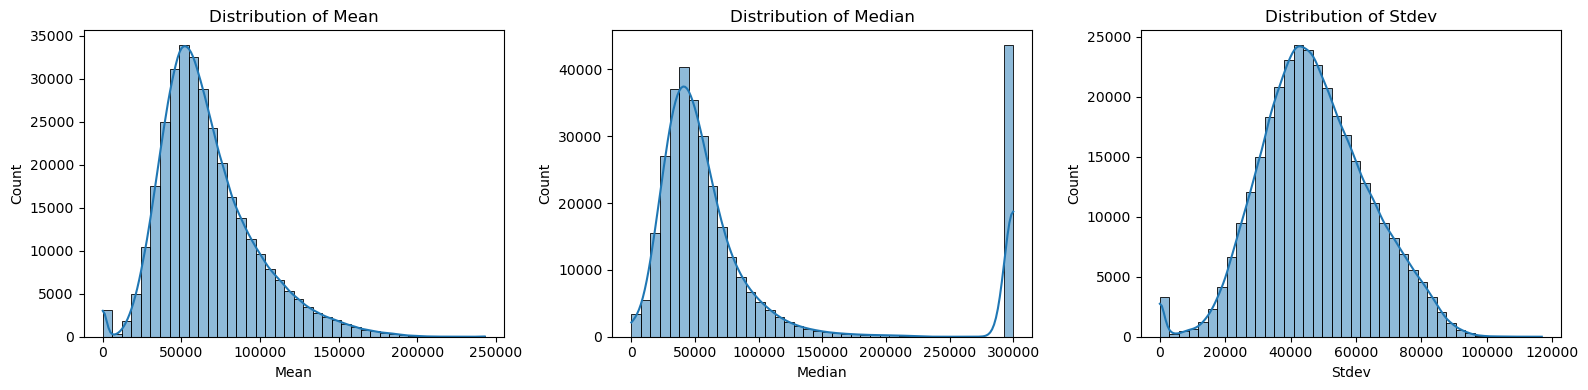

In [31]:
# 2.1 Histograms for Mean, Median, Stdev
income_cols = ["Mean", "Median", "Stdev"]
existing_income_cols = [c for c in income_cols if c in df.columns]

print("\nIncome-related columns found:", existing_income_cols)

plt.figure(figsize=(16, 4))
for i, col in enumerate(existing_income_cols, 1):
    plt.subplot(1, len(existing_income_cols), i)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.savefig(PROCESSED_DIR + "income_histograms.png", dpi=300, bbox_inches='tight')
plt.show()

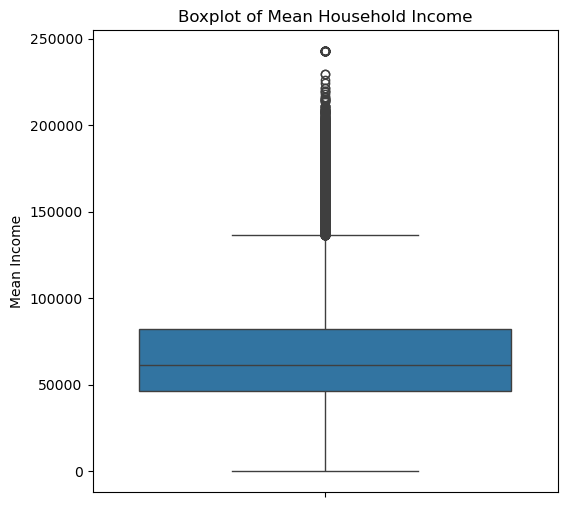

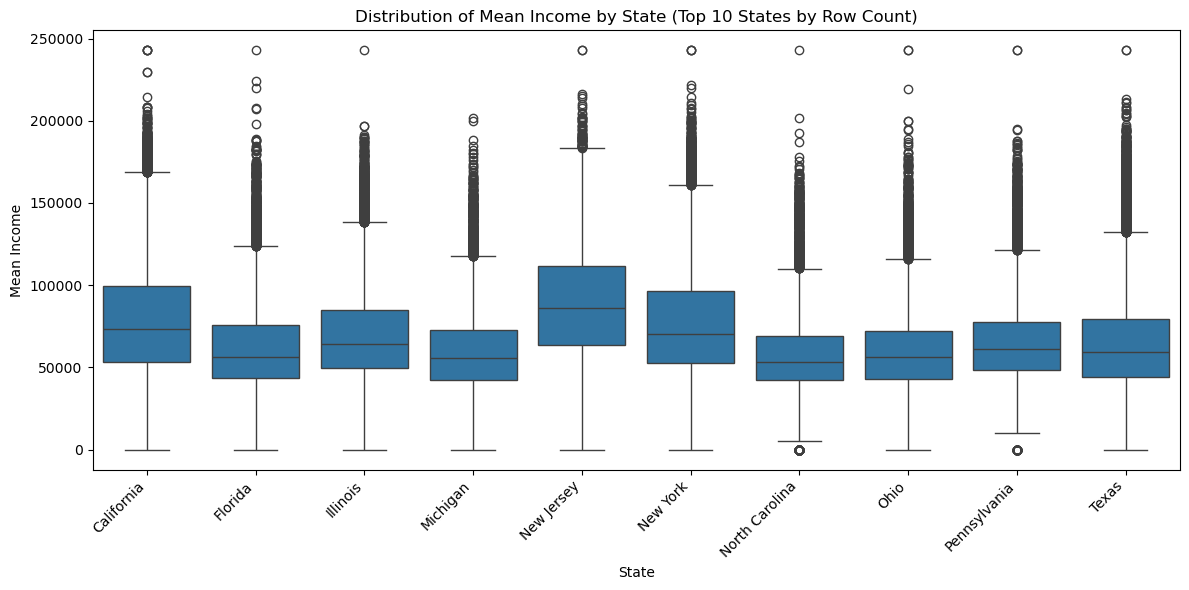

In [32]:
# 2.2 Income distribution plots

# Boxplot of Mean income
if "Mean" in df.columns:
    plt.figure(figsize=(6, 6))
    sns.boxplot(y=df["Mean"])
    plt.title("Boxplot of Mean Household Income")
    plt.ylabel("Mean Income")
    plt.show()

# If states exist, visualize distribution of Mean by State (top N states by count)
if {"State_Name", "Mean"}.issubset(df.columns):
    # Compute top 10 states by number of rows
    top_states = (
        df["State_Name"]
        .value_counts()
        .head(10)
        .index
        .tolist()
    )
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df[df["State_Name"].isin(top_states)],
        x="State_Name",
        y="Mean"
    )
    plt.title("Distribution of Mean Income by State (Top 10 States by Row Count)")
    plt.xlabel("State")
    plt.ylabel("Mean Income")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR + "mean_income_top10.png", dpi=300, bbox_inches='tight')
    plt.show()

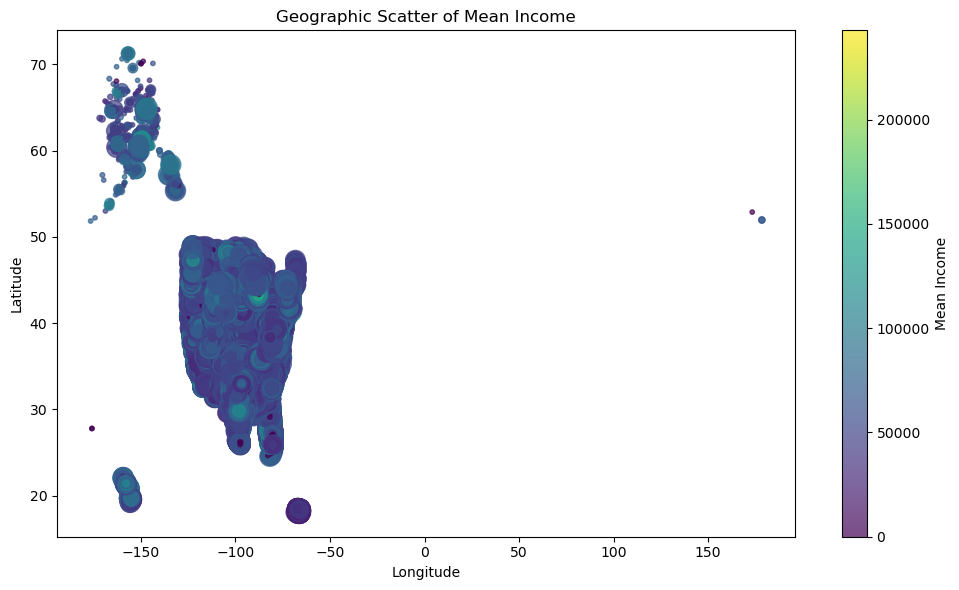

In [33]:
# 2.3 Scatter maps: income vs location and weight

geo_cols = {"Lat", "Lon"}
has_geo = geo_cols.issubset(df.columns)
has_sumw = "sum_w" in df.columns

if has_geo and "Mean" in df.columns:
    # Drop rows with missing coordinates or income
    geo_df = df.dropna(subset=["Lat", "Lon", "Mean"]).copy()
    
    # For size, use sum_w if available, otherwise constant size
    if has_sumw:
        # Scale sum_w for nicer plotting
        s = np.clip(geo_df["sum_w"], a_min=geo_df["sum_w"].quantile(0.05), a_max=geo_df["sum_w"].quantile(0.95))
        size = (s - s.min()) / (s.max() - s.min() + 1e-9) * 200 + 10  # between 10 and ~210
    else:
        size = 30  # constant size
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        x=geo_df["Lon"],
        y=geo_df["Lat"],
        c=geo_df["Mean"],
        s=size,
        alpha=0.7
    )
    plt.colorbar(scatter, label="Mean Income")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geographic Scatter of Mean Income")
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR + "GeographicScatter_MeanIncome.png", dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("⚠ Skipping geographic scatter plot — Lat/Lon/Mean missing.")

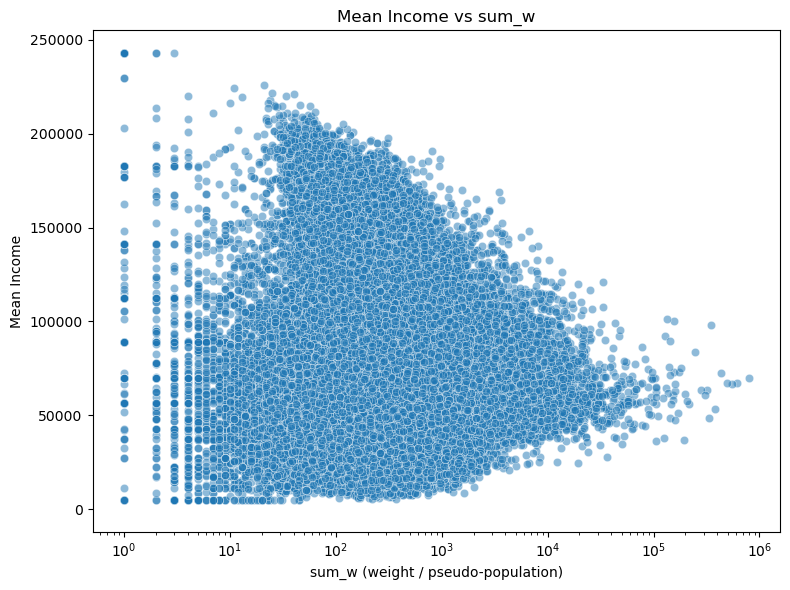

In [34]:
# 2.4 Scatter: Mean Income vs sum_w (weight / pseudo-population)

if "Mean" in df.columns and "sum_w" in df.columns:
    plt.figure(figsize=(8, 6))
    
    # Use log-scale for sum_w if it’s highly skewed
    x = df["sum_w"]
    y = df["Mean"]
    
    # Remove rows with missing
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]
    
    sns.scatterplot(x=x, y=y, alpha=0.5)
    plt.xlabel("sum_w (weight / pseudo-population)")
    plt.ylabel("Mean Income")
    plt.title("Mean Income vs sum_w")
    plt.xscale("log")  # often helpful for heavy-tailed weights
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR + "Weight_vs_Population.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠ Skipping Mean vs sum_w scatter — columns missing.")


Numeric columns used for correlation matrix:
['id', 'State_Code', 'Zip_Code', 'ALand', 'AWater', 'Lat', 'Lon', 'Mean', 'Median', 'Stdev', 'sum_w']


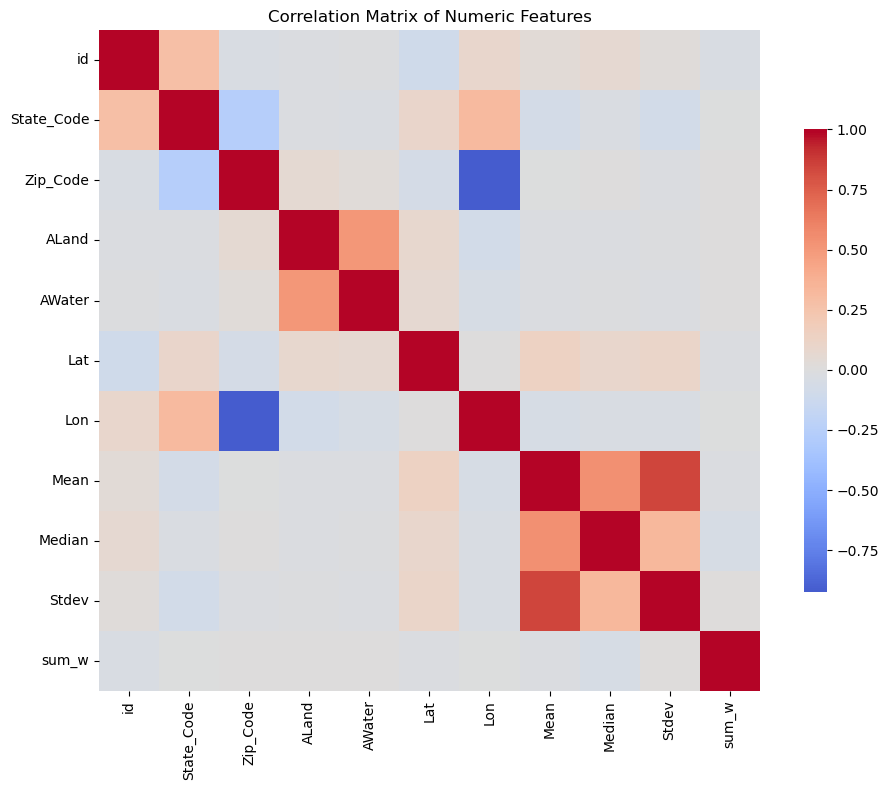

In [35]:
# 2.5 Correlation matrix (heatmap)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\nNumeric columns used for correlation matrix:")
print(numeric_cols)

corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.savefig(PROCESSED_DIR + "Correlation_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# SECTION 3 — Statistical Queries (Non-DP Baseline)

required_cols = ["State_Name", "Mean", "Median", "Stdev"]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("❌ Missing required columns:", missing)
else:
    print("✔ All required columns found.")

✔ All required columns found.


In [38]:
print("\nComputing baseline statistics per state...")

state_stats = df.groupby("State_Name").agg({
    "Mean": "mean",
    "Median": "median",
    "Stdev": "mean"        # Usually stdev should be aggregated differently, 
                           # but your dataset already has per-row stdev values.
}).rename(columns={
    "Mean": "State_MeanIncome",
    "Median": "State_MedianIncome",
    "Stdev": "State_StdevIncome"
})


Computing baseline statistics per state...


In [39]:
# 3.2 Inequality Ratio = Stdev / Mean

state_stats["Inequality_Ratio"] = (
    state_stats["State_StdevIncome"] / state_stats["State_MeanIncome"]
)

print("\n✔ Baseline inequality ratio computed.")


✔ Baseline inequality ratio computed.


In [40]:
# 3.3 Save into baseline_stats dictionary
baseline_stats = {
    "state_mean_income": state_stats["State_MeanIncome"].to_dict(),
    "state_median_income": state_stats["State_MedianIncome"].to_dict(),
    "state_stdev_income": state_stats["State_StdevIncome"].to_dict(),
    "state_inequality_ratio": state_stats["Inequality_Ratio"].to_dict(),
    "full_state_dataframe": state_stats  # convenient for later DP evaluation
}

print("\n✔ Baseline statistics dictionary created:")
print("Keys in baseline_stats:", list(baseline_stats.keys()))


✔ Baseline statistics dictionary created:
Keys in baseline_stats: ['state_mean_income', 'state_median_income', 'state_stdev_income', 'state_inequality_ratio', 'full_state_dataframe']


In [41]:
# 3.4 Display Results for Inspection
print("\n========== BASELINE STATE-LEVEL STATISTICS ==========")
display(state_stats.head(15))


========== BASELINE STATE-LEVEL STATISTICS ==========


,State_MeanIncome,State_MedianIncome,State_StdevIncome,Inequality_Ratio
State_Name,,,,
Alabama,53549.837457,39615.5,42014.471831,0.784586
Alaska,73461.356398,67904.0,48921.791469,0.665953
Arizona,62840.839792,48840.0,43943.431977,0.699281
Arkansas,51109.237563,37790.0,40652.412717,0.795402
California,78650.141394,65296.0,53898.916542,0.685300
Colorado,74432.324725,61567.0,49993.992404,0.671670
Connecticut,88084.286717,79490.0,57656.458298,0.654560
Delaware,73794.475917,59351.0,51592.268349,0.699135
District of Columbia,91846.434921,75776.5,62716.184127,0.682837


In [43]:
state_stats.to_csv(PROCESSED_DIR +"baseline_state_stats.csv", index=True)

In [45]:
import math
from numpy.random import laplace, normal

print("Section 4 — Differential Privacy (Laplace + Gaussian Mechanisms)")

Section 4 — Differential Privacy (Laplace + Gaussian Mechanisms)


In [46]:
# 4.1 Sensitivity Functions
income_min = df["Mean"].min()
income_max = df["Mean"].max()

print(f"Income bounds: min={income_min:.2f}, max={income_max:.2f}")

def delta_mean(n):
    """Sensitivity of the mean: (max-min)/n"""
    return (income_max - income_min) / n

def delta_median(n):
    """Sensitivity of the median: approximate"""
    return (income_max - income_min) / n

def delta_stdev(n):
    """Sensitivity of stdev: safe upper bound"""
    return (income_max - income_min) / n

print("✔ Sensitivity functions defined.")

Income bounds: min=0.00, max=242857.00
✔ Sensitivity functions defined.


In [47]:
# 4.2 Implement Laplace and Gaussian Mechanisms
def laplace_mechanism(value, sensitivity, epsilon):
    scale = sensitivity / epsilon
    noise = laplace(loc=0.0, scale=scale)
    return value + noise

def gaussian_mechanism(value, sensitivity, epsilon, delta=1e-5):
    sigma = math.sqrt(2 * math.log(1.25 / delta)) * sensitivity / epsilon
    noise = normal(loc=0.0, scale=sigma)
    return value + noise

print("✔ Laplace and Gaussian mechanisms implemented.")

✔ Laplace and Gaussian mechanisms implemented.


In [51]:
print(state_df.columns)

Index(['State_MeanIncome', 'State_MedianIncome', 'State_StdevIncome', 'Inequality_Ratio'], dtype='object')


In [52]:
print(state_df.head())

            State_MeanIncome  State_MedianIncome  State_StdevIncome  Inequality_Ratio
State_Name                                                                           
Alabama         53549.837457             39615.5       42014.471831          0.784586
Alaska          73461.356398             67904.0       48921.791469          0.665953
Arizona         62840.839792             48840.0       43943.431977          0.699281
Arkansas        51109.237563             37790.0       40652.412717          0.795402
California      78650.141394             65296.0       53898.916542          0.685300


In [53]:
# 4.3 Run DP Queries across epsilon values

epsilon_values = [0.05, 0.1, 0.5, 1, 2, 5]
dp_results = []

state_df = baseline_stats["full_state_dataframe"]

print("Running DP queries for all states and all epsilons...")

for eps in epsilon_values:
    for state, row in state_df.iterrows():

        # Retrieve row count (must exist in state_df)
        n = df[df["State_Name"] == state].shape[0]

        # Safety: avoid division by zero (states with 0 rows)
        if n < 1:
            continue

        # Sensitivities
        dm = delta_mean(n)
        dmed = delta_median(n)
        ds = delta_stdev(n)

        # True (non-DP) baseline values
        true_mean = row["State_MeanIncome"]
        true_median = row["State_MedianIncome"]
        true_stdev = row["State_StdevIncome"]

        # Laplace DP
        dp_mean_lap = laplace_mechanism(true_mean, dm, eps)
        dp_median_lap = laplace_mechanism(true_median, dmed, eps)
        dp_stdev_lap = laplace_mechanism(true_stdev, ds, eps)

        # Gaussian DP
        dp_mean_gauss = gaussian_mechanism(true_mean, dm, eps)
        dp_median_gauss = gaussian_mechanism(true_median, dmed, eps)
        dp_stdev_gauss = gaussian_mechanism(true_stdev, ds, eps)

        # Save record
        dp_results.append({
            "State": state,
            "epsilon": eps,

            # True (baseline)
            "true_mean": true_mean,
            "true_median": true_median,
            "true_stdev": true_stdev,

            # Laplace DP
            "dp_mean_laplace": dp_mean_lap,
            "dp_median_laplace": dp_median_lap,
            "dp_stdev_laplace": dp_stdev_lap,

            # Gaussian DP
            "dp_mean_gaussian": dp_mean_gauss,
            "dp_median_gaussian": dp_median_gauss,
            "dp_stdev_gaussian": dp_stdev_gauss,

            # Absolute Errors (Laplace)
            "abs_err_mean_lap": abs(dp_mean_lap - true_mean),
            "abs_err_median_lap": abs(dp_median_lap - true_median),
            "abs_err_stdev_lap": abs(dp_stdev_lap - true_stdev),

            # Absolute Errors (Gaussian)
            "abs_err_mean_gauss": abs(dp_mean_gauss - true_mean),
            "abs_err_median_gauss": abs(dp_median_gauss - true_median),
            "abs_err_stdev_gauss": abs(dp_stdev_gauss - true_stdev),
        })

print("✔ DP Query Generation Complete!")

Running DP queries for all states and all epsilons...
✔ DP Query Generation Complete!


In [54]:
dp_df = pd.DataFrame(dp_results)
print("\nDP Results Shape:", dp_df.shape)
dp_df.head()


DP Results Shape: (312, 17)


,State,epsilon,true_mean,true_median,true_stdev,dp_mean_laplace,dp_median_laplace,dp_stdev_laplace,dp_mean_gaussian,dp_median_gaussian,dp_stdev_gaussian,abs_err_mean_lap,abs_err_median_lap,abs_err_stdev_lap,abs_err_mean_gauss,abs_err_median_gauss,abs_err_stdev_gauss
0,Alabama,0.05,53549.837457,39615.5,42014.471831,52880.908445,39864.769248,41477.292442,55833.792770,38793.871126,44266.570355,668.929012,249.269248,537.179389,2283.955312,821.628874,2252.098524
1,Alaska,0.05,73461.356398,67904.0,48921.791469,72407.362004,70407.106357,49708.291644,79820.171065,53451.441147,77261.741795,1053.994394,2503.106357,786.500175,6358.814667,14452.558853,28339.950326
2,Arizona,0.05,62840.839792,48840.0,43943.431977,61451.287462,49825.233699,43960.941405,61047.011768,44801.062933,46785.766917,1389.552331,985.233699,17.509428,1793.828024,4038.937067,2842.334940
3,Arkansas,0.05,51109.237563,37790.0,40652.412717,50485.346263,42112.798889,40533.700831,56810.854269,33820.022258,43492.300152,623.891299,4322.798889,118.711886,5701.616706,3969.977742,2839.887435
4,California,0.05,78650.141394,65296.0,53898.916542,78357.600455,65505.738661,53863.165750,79420.305005,65617.075916,52828.717141,292.540939,209.738661,35.750792,770.163611,321.075916,1070.199401


In [55]:
dp_df.to_csv(PROCESSED_DIR +"dp_state_statistics.csv", index=False)

print("✔ DP results saved")

✔ DP results saved


In [56]:
# SECTION 5 — Privacy-Utility Trade-Off Analysis

print("Section 5 — Privacy-Utility Trade-Off Analysis")

# 5.0 Load DP results if not in memory

if 'dp_df' not in globals():
    dp_csv_path = "C:/Users/addme/Downloads/CIS545_Project/Processed/dp_state_statistics.csv"
    print(f"dp_df not found in memory. Loading from {dp_csv_path} ...")
    dp_df = pd.read_csv(dp_csv_path)
else:
    print("Using existing dp_df from memory.")

print("dp_df shape:", dp_df.shape)
display(dp_df.head())

Section 5 — Privacy-Utility Trade-Off Analysis
Using existing dp_df from memory.
dp_df shape: (312, 17)


,State,epsilon,true_mean,true_median,true_stdev,dp_mean_laplace,dp_median_laplace,dp_stdev_laplace,dp_mean_gaussian,dp_median_gaussian,dp_stdev_gaussian,abs_err_mean_lap,abs_err_median_lap,abs_err_stdev_lap,abs_err_mean_gauss,abs_err_median_gauss,abs_err_stdev_gauss
0,Alabama,0.05,53549.837457,39615.5,42014.471831,52880.908445,39864.769248,41477.292442,55833.792770,38793.871126,44266.570355,668.929012,249.269248,537.179389,2283.955312,821.628874,2252.098524
1,Alaska,0.05,73461.356398,67904.0,48921.791469,72407.362004,70407.106357,49708.291644,79820.171065,53451.441147,77261.741795,1053.994394,2503.106357,786.500175,6358.814667,14452.558853,28339.950326
2,Arizona,0.05,62840.839792,48840.0,43943.431977,61451.287462,49825.233699,43960.941405,61047.011768,44801.062933,46785.766917,1389.552331,985.233699,17.509428,1793.828024,4038.937067,2842.334940
3,Arkansas,0.05,51109.237563,37790.0,40652.412717,50485.346263,42112.798889,40533.700831,56810.854269,33820.022258,43492.300152,623.891299,4322.798889,118.711886,5701.616706,3969.977742,2839.887435
4,California,0.05,78650.141394,65296.0,53898.916542,78357.600455,65505.738661,53863.165750,79420.305005,65617.075916,52828.717141,292.540939,209.738661,35.750792,770.163611,321.075916,1070.199401


In [57]:
# 5.1 Metric computation helper

def compute_metrics_for_pair(df, true_col, dp_col, group_col="epsilon"):
    """
    Compute MAE, RMSE, Bias, Relative Error for each group (epsilon)
    between true_col and dp_col.
    Returns: DataFrame with one row per epsilon.
    """
    results = []
    for eps, g in df.groupby(group_col):
        true_vals = g[true_col].values
        dp_vals = g[dp_col].values

        diff = dp_vals - true_vals
        abs_diff = np.abs(diff)

        mae = abs_diff.mean()
        rmse = np.sqrt((diff ** 2).mean())
        bias = diff.mean()
        rel_err = (abs_diff / (np.abs(true_vals) + 1e-9)).mean()

        results.append({
            "epsilon": eps,
            "MAE": mae,
            "RMSE": rmse,
            "Bias": bias,
            "RelativeError": rel_err
        })
    return pd.DataFrame(results)

In [58]:
# 5.2 Compute MAE, RMSE, Bias, Relative Error for all combinations

metrics_records = []

# --- Mean ---
mean_lap = compute_metrics_for_pair(dp_df, "true_mean", "dp_mean_laplace")
mean_lap["Mechanism"] = "Laplace"
mean_lap["Statistic"] = "Mean"

mean_gauss = compute_metrics_for_pair(dp_df, "true_mean", "dp_mean_gaussian")
mean_gauss["Mechanism"] = "Gaussian"
mean_gauss["Statistic"] = "Mean"

metrics_records.append(mean_lap)
metrics_records.append(mean_gauss)

# --- Median ---
med_lap = compute_metrics_for_pair(dp_df, "true_median", "dp_median_laplace")
med_lap["Mechanism"] = "Laplace"
med_lap["Statistic"] = "Median"

med_gauss = compute_metrics_for_pair(dp_df, "true_median", "dp_median_gaussian")
med_gauss["Mechanism"] = "Gaussian"
med_gauss["Statistic"] = "Median"

metrics_records.append(med_lap)
metrics_records.append(med_gauss)

# --- Stdev ---
std_lap = compute_metrics_for_pair(dp_df, "true_stdev", "dp_stdev_laplace")
std_lap["Mechanism"] = "Laplace"
std_lap["Statistic"] = "Stdev"

std_gauss = compute_metrics_for_pair(dp_df, "true_stdev", "dp_stdev_gaussian")
std_gauss["Mechanism"] = "Gaussian"
std_gauss["Statistic"] = "Stdev"

metrics_records.append(std_lap)
metrics_records.append(std_gauss)

# Concatenate all
dp_metrics_df = pd.concat(metrics_records, ignore_index=True)

print("dp_metrics_df shape:", dp_metrics_df.shape)
display(dp_metrics_df.head(12))

dp_metrics_df shape: (36, 7)


,epsilon,MAE,RMSE,Bias,RelativeError,Mechanism,Statistic
0,0.05,1657.594751,3377.990416,-99.000048,0.024840,Laplace,Mean
1,0.10,1011.054625,2387.494330,223.653821,0.014943,Laplace,Mean
2,0.50,168.842409,314.837574,2.675170,0.002687,Laplace,Mean
3,1.00,92.438632,163.496623,42.332480,0.001425,Laplace,Mean
4,2.00,52.820801,110.282039,21.599474,0.000773,Laplace,Mean
5,5.00,19.296883,39.260995,4.899592,0.000303,Laplace,Mean
6,0.05,6532.563664,12236.125388,2683.128915,0.099075,Gaussian,Mean
7,0.10,3393.326955,7095.936269,1312.154844,0.052063,Gaussian,Mean
8,0.50,612.712583,1064.340886,-107.679897,0.009384,Gaussian,Mean
9,1.00,337.569049,539.311951,79.051554,0.005271,Gaussian,Mean


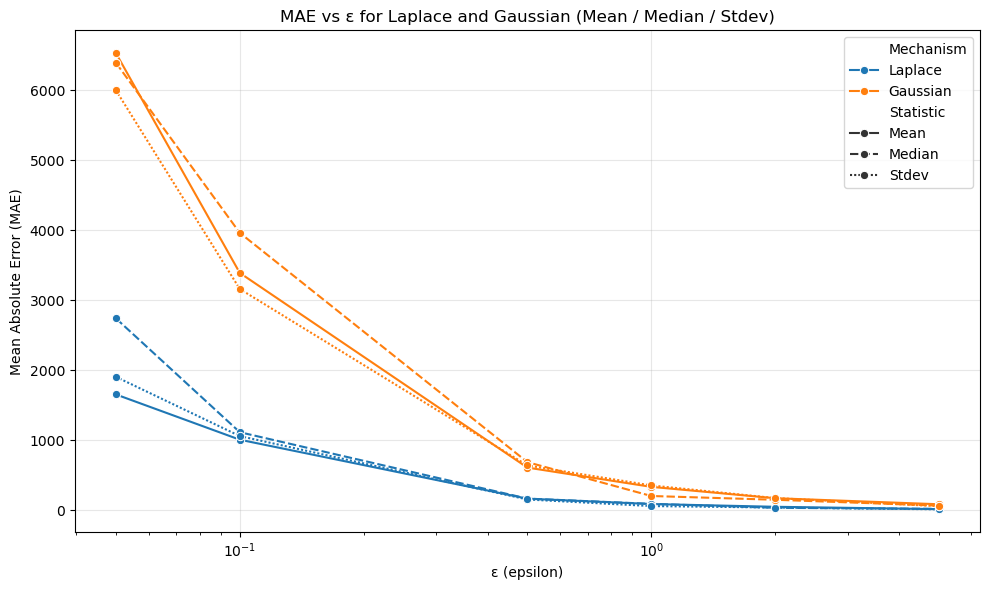

In [59]:
# 5.3 Utility vs epsilon curves (MAE)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_metrics_df,
    x="epsilon",
    y="MAE",
    hue="Mechanism",
    style="Statistic",
    marker="o"
)
plt.title("MAE vs ε for Laplace and Gaussian (Mean / Median / Stdev)")
plt.xlabel("ε (epsilon)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xscale("log")  # optional: eps values are often log-scaled
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROCESSED_DIR + "Utility_vs_epsilon_curves.png", dpi=300, bbox_inches='tight')
plt.show()

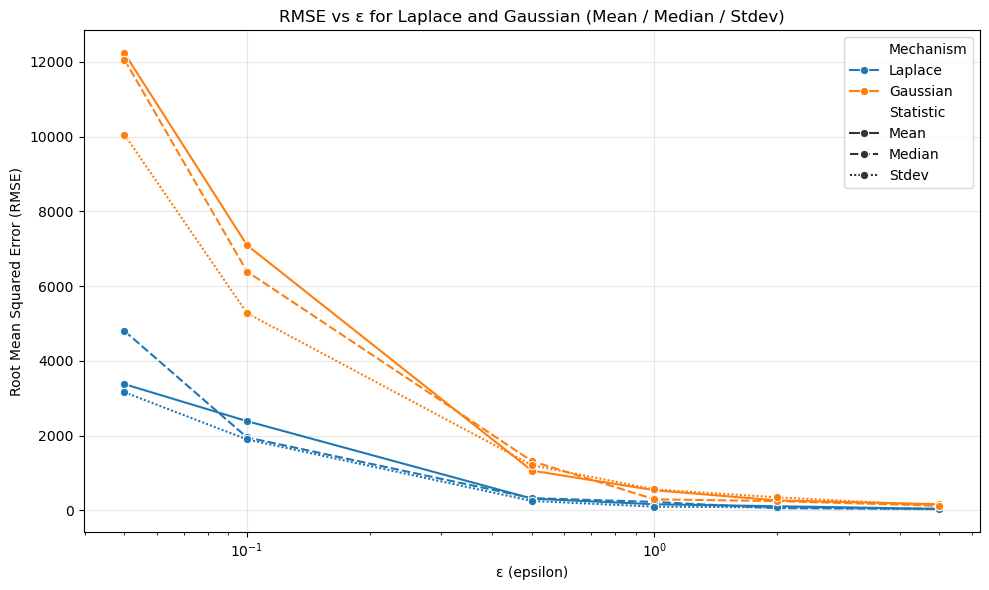

In [60]:
# 5.4 Additional comparison plots (RMSE, Bias, Relative Error)

# RMSE
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_metrics_df,
    x="epsilon",
    y="RMSE",
    hue="Mechanism",
    style="Statistic",
    marker="o"
)
plt.title("RMSE vs ε for Laplace and Gaussian (Mean / Median / Stdev)")
plt.xlabel("ε (epsilon)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROCESSED_DIR + "RMSE.png", dpi=300, bbox_inches='tight')
plt.show()

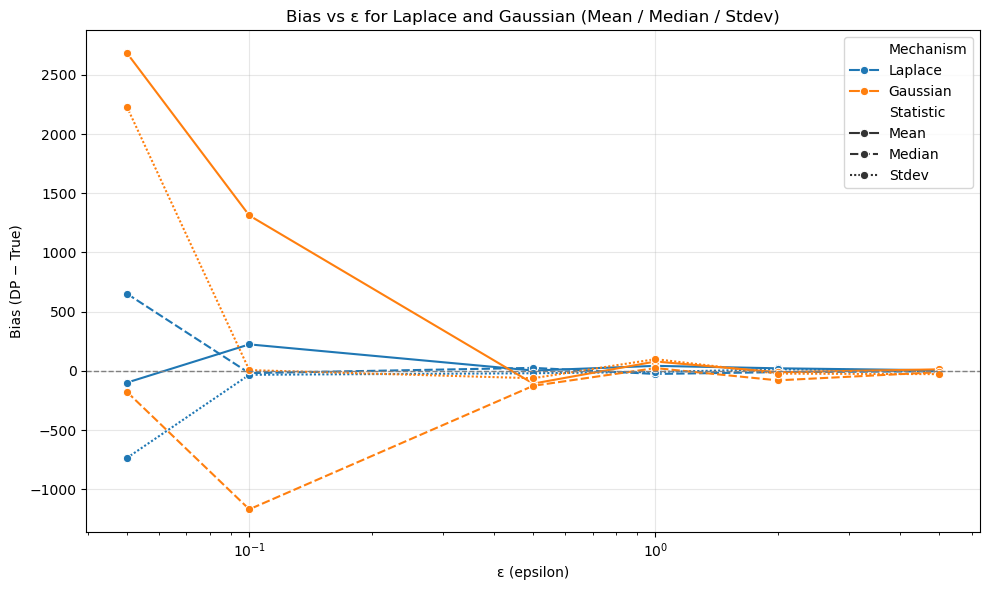

In [61]:
# Bias
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_metrics_df,
    x="epsilon",
    y="Bias",
    hue="Mechanism",
    style="Statistic",
    marker="o"
)
plt.title("Bias vs ε for Laplace and Gaussian (Mean / Median / Stdev)")
plt.xlabel("ε (epsilon)")
plt.ylabel("Bias (DP − True)")
plt.xscale("log")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROCESSED_DIR + "BIAS.png", dpi=300, bbox_inches='tight')
plt.show()

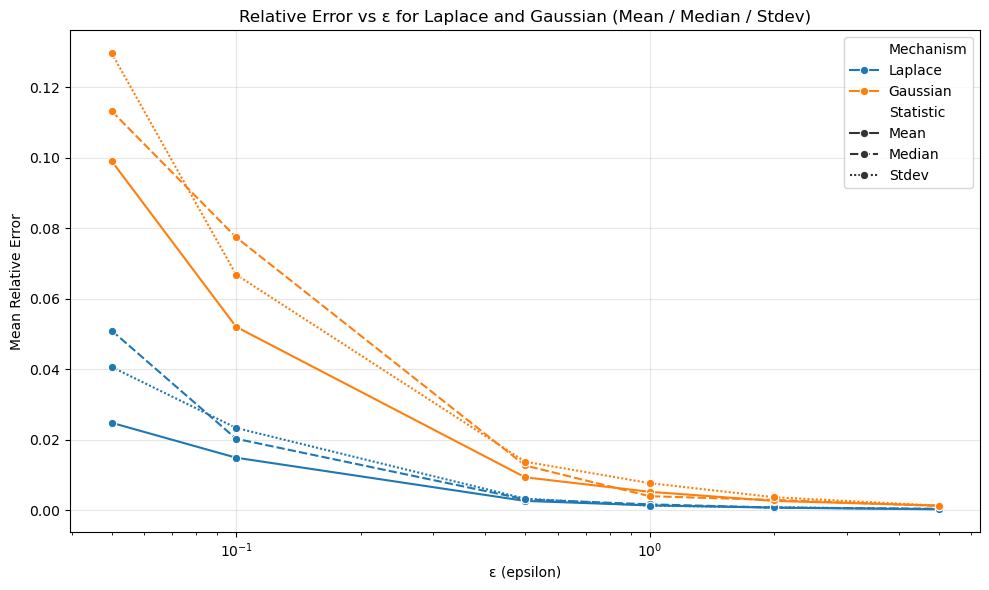

In [62]:
# Relative Error
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_metrics_df,
    x="epsilon",
    y="RelativeError",
    hue="Mechanism",
    style="Statistic",
    marker="o"
)
plt.title("Relative Error vs ε for Laplace and Gaussian (Mean / Median / Stdev)")
plt.xlabel("ε (epsilon)")
plt.ylabel("Mean Relative Error")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROCESSED_DIR + "Relative_Error.png", dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# 5.5 Save metrics to CSV for report

dp_df.to_csv(PROCESSED_DIR +"dp_privacy_utility_matrix.csv", index=False)
print("✔ DP metrics saved")

✔ DP metrics saved


In [65]:
print("Section 6 — Machine Learning Component")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
import os

Section 6 — Machine Learning Component


In [66]:
# 6.1 Split Data (X, y, train/test)

print("Columns in df:", df.columns.tolist())

if "Mean" not in df.columns:
    raise ValueError("Column 'Mean' not found in df. Cannot build regression target.")

# Select numeric columns as candidates for features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target from feature list
feature_cols = [c for c in numeric_cols if c != "Mean"]

print("Numeric feature columns used for X:")
print(feature_cols)

Columns in df: ['id', 'State_Code', 'State_Name', 'State_ab', 'County', 'City', 'Place', 'Type', 'Primary', 'Zip_Code', 'Area_Code', 'ALand', 'AWater', 'Lat', 'Lon', 'Mean', 'Median', 'Stdev', 'sum_w']
Numeric feature columns used for X:
['id', 'State_Code', 'Zip_Code', 'ALand', 'AWater', 'Lat', 'Lon', 'Median', 'Stdev', 'sum_w']


In [67]:
# Build X and y
X = df[feature_cols].copy()
y = df["Mean"].copy()

# Drop rows with any NaNs in features or target
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print("Final ML dataset shape:", X.shape, y.shape)

Final ML dataset shape: (325259, 10) (325259,)


In [68]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (260207, 10) Test shape: (65052, 10)


In [69]:
# Standardize features (this scaler will be shared with both models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
scaler_path = os.path.join(PROCESSED_DIR, "ml_feature_scaler.pkl")
joblib.dump(scaler, scaler_path)
print("✔ Saved StandardScaler to:", scaler_path)

✔ Saved StandardScaler to: C:/Users/addme/Downloads/CIS545_Project/Processed/ml_feature_scaler.pkl


In [70]:
# 6.2 Baseline Regression (Non-DP): Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = lin_reg.predict(X_test_scaled)

# Metrics
baseline_mae = mean_absolute_error(y_test, y_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
baseline_r2 = r2_score(y_test, y_pred)

print("\n===== Baseline Linear Regression Performance =====")
print(f"MAE  : {baseline_mae:.4f}")
print(f"RMSE : {baseline_rmse:.4f}")
print(f"R^2  : {baseline_r2:.4f}")


===== Baseline Linear Regression Performance =====
MAE  : 9830.4525
RMSE : 13921.5660
R^2  : 0.7906


In [71]:
# Save model
baseline_model_path = os.path.join(PROCESSED_DIR, "baseline_linear_regression.pkl")
joblib.dump(lin_reg, baseline_model_path)
print("✔ Saved baseline Linear Regression model to:", baseline_model_path)

✔ Saved baseline Linear Regression model to: C:/Users/addme/Downloads/CIS545_Project/Processed/baseline_linear_regression.pkl


In [72]:
# Save test predictions for analysis
baseline_pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred
}, index=y_test.index)
baseline_pred_path = os.path.join(PROCESSED_DIR, "baseline_linear_regression_predictions.csv")
baseline_pred_df.to_csv(baseline_pred_path, index=False)
print("✔ Saved baseline predictions to:", baseline_pred_path)

✔ Saved baseline predictions to: C:/Users/addme/Downloads/CIS545_Project/Processed/baseline_linear_regression_predictions.csv


In [80]:
# 6.3 DP-SGD Model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n======= DP-SGD (Pure NumPy Implementation) =======")

# 1. Prepare dataset (already scaled in your notebook)
X_train_np = X_train_scaled.astype(np.float64)
X_test_np  = X_test_scaled.astype(np.float64)
y_train_np = y_train.values.astype(np.float64)
y_test_np  = y_test.values.astype(np.float64)

n_samples, n_features = X_train_np.shape

# 2. Hyperparameters
lr = 0.01
batch_size = 128
epochs = 30

l2_clip = 1.0               # gradient clipping norm
noise_multiplier = 1.0      # Gaussian noise multiplier
delta = 1e-5                # used for privacy accounting (not needed in pure DP-SGD)

# Model parameters (Linear Regression)
W = np.zeros(n_features)    # weights
b = 0.0                     # bias

loss_history = []

# 3. DP-SGD training loop
for epoch in range(epochs):
    # Shuffle data
    idx = np.random.permutation(n_samples)
    X_shuf = X_train_np[idx]
    y_shuf = y_train_np[idx]

    batch_losses = []

    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        X_batch = X_shuf[start:end]
        y_batch = y_shuf[start:end]

        if len(X_batch) == 0:
            continue

        # Step 1: Forward Pass
        preds = X_batch.dot(W) + b
        errors = preds - y_batch

        # Step 2: Per-example gradients
        grad_W = (errors[:, None] * X_batch)       # shape: (B, d)
        grad_b = errors                             # shape: (B,)

        # Step 3: Gradient Clipping
        grad_norms = np.linalg.norm(grad_W, axis=1)

        clip_factor = np.minimum(1.0, l2_clip / (grad_norms + 1e-8))

        grad_W_clipped = grad_W * clip_factor[:, None]
        grad_b_clipped = grad_b * clip_factor

        # Step 4: Average clipped gradients
        grad_W_avg = grad_W_clipped.mean(axis=0)
        grad_b_avg = grad_b_clipped.mean()

        # Step 5: Add Gaussian noise (DP)
        noise_W = np.random.normal(0, noise_multiplier * l2_clip / batch_size, size=W.shape)
        noise_b = np.random.normal(0, noise_multiplier * l2_clip / batch_size)

        grad_W_noisy = grad_W_avg + noise_W
        grad_b_noisy = grad_b_avg + noise_b

        # Step 6: Gradient Descent update
        W -= lr * grad_W_noisy
        b -= lr * grad_b_noisy

        # Track batch loss (non-private MSE)
        batch_losses.append(np.mean(errors**2))

    epoch_loss = np.mean(batch_losses)
    loss_history.append(epoch_loss)

    print(f"Epoch {epoch+1:02d}/{epochs} - Loss: {epoch_loss:.4f}")

print("✔ DP-SGD Training Complete!")

# 4. Evaluation
y_pred = X_test_np.dot(W) + b

dp_mae  = mean_absolute_error(y_test_np, y_pred)
dp_rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
dp_r2   = r2_score(y_test_np, y_pred)

print("\n===== DP-SGD Model Performance =====")
print(f"MAE  : {dp_mae:.4f}")
print(f"RMSE : {dp_rmse:.4f}")
print(f"R^2  : {dp_r2:.4f}")

# 5. Save model + predictions + history
model_path = os.path.join(PROCESSED_DIR, "dp_sgd_numpy_weights.npz")
np.savez(model_path, W=W, b=b)
print("✔ Saved DP model weights to:", model_path)

pred_path = os.path.join(PROCESSED_DIR, "dp_sgd_numpy_predictions.csv")
pd.DataFrame({"y_true": y_test_np, "y_pred_dp": y_pred}).to_csv(pred_path, index=False)
print("✔ Saved DP predictions to:", pred_path)

history_path = os.path.join(PROCESSED_DIR, "dp_sgd_numpy_history.csv")
pd.DataFrame({"loss": loss_history}).to_csv(history_path, index=False)
print("✔ Saved DP training history to:", history_path)



======= DP-SGD (Pure NumPy Implementation) =======
Epoch 01/30 - Loss: 5422700177.6482
Epoch 02/30 - Loss: 5421496662.0969
Epoch 03/30 - Loss: 5420216068.0113
Epoch 04/30 - Loss: 5419023956.7764
Epoch 05/30 - Loss: 5417812346.3694
Epoch 06/30 - Loss: 5416567815.3494
Epoch 07/30 - Loss: 5415382325.7936
Epoch 08/30 - Loss: 5414254997.9291
Epoch 09/30 - Loss: 5412953222.4726
Epoch 10/30 - Loss: 5411681936.6334
Epoch 11/30 - Loss: 5410512721.0069
Epoch 12/30 - Loss: 5409365524.6689
Epoch 13/30 - Loss: 5408080497.1117
Epoch 14/30 - Loss: 5406932286.4965
Epoch 15/30 - Loss: 5405716358.3130
Epoch 16/30 - Loss: 5404458100.2731
Epoch 17/30 - Loss: 5403227456.0605
Epoch 18/30 - Loss: 5401980730.6971
Epoch 19/30 - Loss: 5400856467.2836
Epoch 20/30 - Loss: 5399657602.4932
Epoch 21/30 - Loss: 5398383748.9077
Epoch 22/30 - Loss: 5397159745.2211
Epoch 23/30 - Loss: 5395945147.2582
Epoch 24/30 - Loss: 5394780076.8591
Epoch 25/30 - Loss: 5393547631.9530
Epoch 26/30 - Loss: 5392308639.7022
Epoch 27/30 

In [81]:
print("Section 7 — ML Results & Plotting")

import os
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style("whitegrid")

Section 7 — ML Results & Plotting


In [82]:
# 7.1 Load baseline & DP predictions

# Baseline (non-DP) predictions
baseline_pred_path = os.path.join(PROCESSED_DIR, "baseline_linear_regression_predictions.csv")
if not os.path.exists(baseline_pred_path):
    raise FileNotFoundError(f"Baseline predictions not found at {baseline_pred_path}")
baseline_pred_df = pd.read_csv(baseline_pred_path)
print("✔ Loaded baseline predictions from:", baseline_pred_path)
display(baseline_pred_df.head())

# DP predictions: try a few candidate filenames
dp_pred_candidates = [
    os.path.join(PROCESSED_DIR, "dp_sgd_regressor_predictions.csv"),
    os.path.join(PROCESSED_DIR, "dp_sgd_numpy_predictions.csv")
]

dp_pred_path = None
for cand in dp_pred_candidates:
    if os.path.exists(cand):
        dp_pred_path = cand
        break

if dp_pred_path is None:
    print("⚠ No DP prediction file found. Skipping DP model comparison.")
    dp_pred_df = None
else:
    dp_pred_df = pd.read_csv(dp_pred_path)
    print("✔ Loaded DP predictions from:", dp_pred_path)
    display(dp_pred_df.head())

✔ Loaded baseline predictions from: C:/Users/addme/Downloads/CIS545_Project/Processed/baseline_linear_regression_predictions.csv


,y_true,y_pred
0,75931,103811.116516
1,50594,63837.447508
2,95510,105625.797473
3,52392,65138.352167
4,90228,80480.149117


✔ Loaded DP predictions from: C:/Users/addme/Downloads/CIS545_Project/Processed/dp_sgd_numpy_predictions.csv


,y_true,y_pred_dp
0,75931.0,227.439160
1,50594.0,229.608363
2,95510.0,145.354008
3,52392.0,307.666635
4,90228.0,275.083521


In [83]:
# 7.2 Compute MAE, RMSE, R² for baseline and DP model

ml_metrics_records = []

# Baseline metrics
y_true_base = baseline_pred_df["y_true"].values
y_pred_base = baseline_pred_df["y_pred"].values

baseline_mae = mean_absolute_error(y_true_base, y_pred_base)
baseline_rmse = np.sqrt(mean_squared_error(y_true_base, y_pred_base))
baseline_r2 = r2_score(y_true_base, y_pred_base)

ml_metrics_records.append({
    "Model": "Baseline Linear Regression",
    "MAE": baseline_mae,
    "RMSE": baseline_rmse,
    "R2": baseline_r2
})

# DP model metrics (if available)
if dp_pred_df is not None:
    # Try to find DP prediction column
    if "y_pred_dp" in dp_pred_df.columns:
        y_pred_dp = dp_pred_df["y_pred_dp"].values
    elif "y_pred" in dp_pred_df.columns:
        y_pred_dp = dp_pred_df["y_pred"].values
    else:
        raise ValueError("Could not find DP prediction column in dp_pred_df (expected 'y_pred_dp' or 'y_pred').")

    # True labels for DP model
    if "y_true" in dp_pred_df.columns:
        y_true_dp = dp_pred_df["y_true"].values
    else:
        # Fall back to baseline y_true if needed (assumes same test set ordering)
        y_true_dp = y_true_base

    dp_mae = mean_absolute_error(y_true_dp, y_pred_dp)
    dp_rmse = np.sqrt(mean_squared_error(y_true_dp, y_pred_dp))
    dp_r2 = r2_score(y_true_dp, y_pred_dp)

    ml_metrics_records.append({
        "Model": "DP-SGD Regressor",
        "MAE": dp_mae,
        "RMSE": dp_rmse,
        "R2": dp_r2
    })
else:
    print("⚠ DP model metrics will not be computed (no DP predictions).")

ml_metrics_df = pd.DataFrame(ml_metrics_records)

print("\n===== ML Model Metrics (Baseline vs DP) =====")
display(ml_metrics_df)

# Save metrics
ml_metrics_path = os.path.join(PROCESSED_DIR, "ml_model_comparison_metrics.csv")
ml_metrics_df.to_csv(ml_metrics_path, index=False)
print("✔ Saved ML model comparison metrics to:", ml_metrics_path)


===== ML Model Metrics (Baseline vs DP) =====


,Model,MAE,RMSE,R2
0,Baseline Linear Regression,9830.452549,13921.566041,0.790562
1,DP-SGD Regressor,66719.305690,73331.444195,-4.811115


✔ Saved ML model comparison metrics to: C:/Users/addme/Downloads/CIS545_Project/Processed/ml_model_comparison_metrics.csv


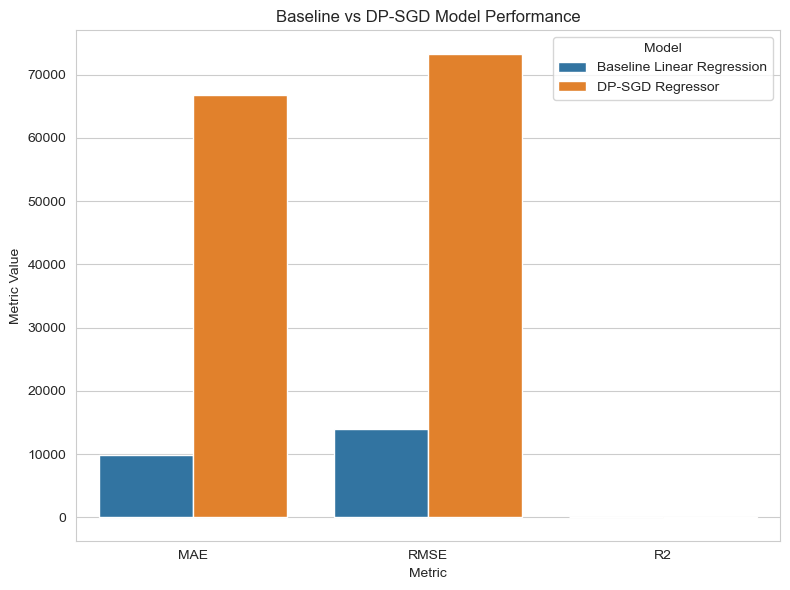

In [84]:
# 7.3 Performance comparison plots (Baseline vs DP)

if len(ml_metrics_df) > 0:
    metrics_melt = ml_metrics_df.melt(id_vars="Model", value_vars=["MAE", "RMSE", "R2"],
                                      var_name="Metric", value_name="Value")

    plt.figure(figsize=(8, 6))
    sns.barplot(data=metrics_melt, x="Metric", y="Value", hue="Model")
    plt.title("Baseline vs DP-SGD Model Performance")
    plt.ylabel("Metric Value")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR + "Performance_Comparison_Plot.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠ No ML metrics to plot.")

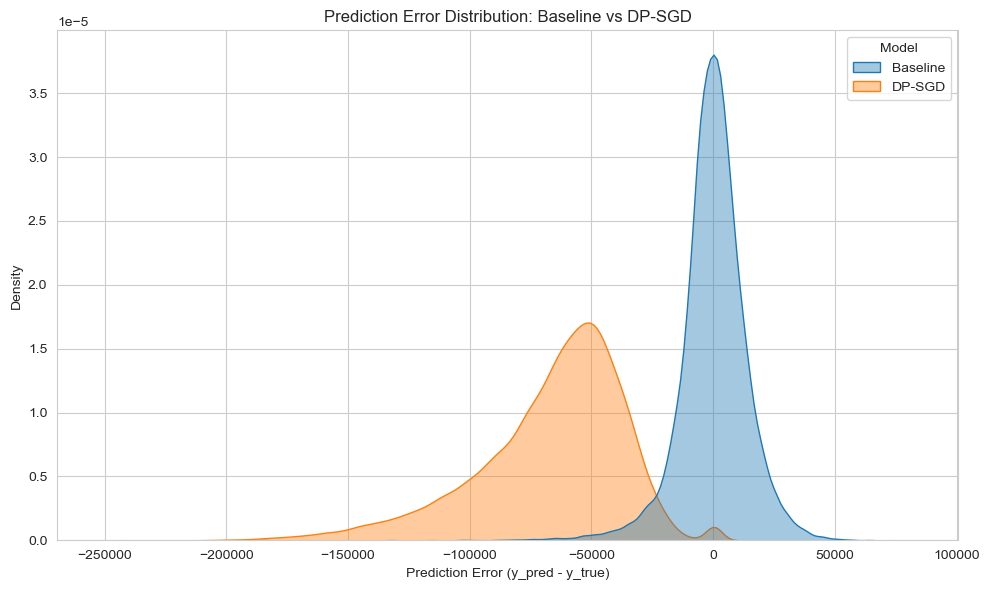

In [85]:
# 7.4 Error distribution: Baseline vs DP

if dp_pred_df is not None:
    base_errors = y_pred_base - y_true_base

    if "y_true" in dp_pred_df.columns:
        y_true_dp = dp_pred_df["y_true"].values
    else:
        y_true_dp = y_true_base  # fallback

    if "y_pred_dp" in dp_pred_df.columns:
        y_pred_dp = dp_pred_df["y_pred_dp"].values
    else:
        y_pred_dp = dp_pred_df["y_pred"].values

    dp_errors = y_pred_dp - y_true_dp

    error_df = pd.DataFrame({
        "Error": np.concatenate([base_errors, dp_errors]),
        "Model": (["Baseline"] * len(base_errors)) + (["DP-SGD"] * len(dp_errors))
    })

    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=error_df, x="Error", hue="Model", fill=True, common_norm=False, alpha=0.4)
    plt.title("Prediction Error Distribution: Baseline vs DP-SGD")
    plt.xlabel("Prediction Error (y_pred - y_true)")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR + "Error_Distribution_Baseline_vs_DP.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠ Skipping error distribution plot (no DP predictions).")

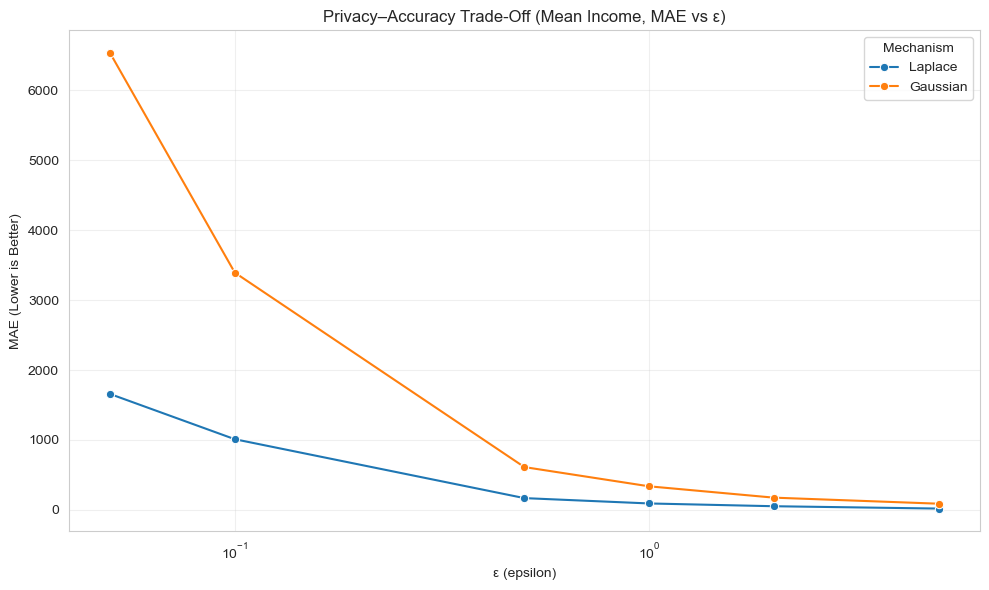

In [86]:
# 7.5 Privacy–accuracy plot (from DP query metrics)

# Try to use in-memory dp_metrics_df, otherwise load from disk
if 'dp_metrics_df' not in globals():
    # Try common file names
    metrics_candidates = [
        "results/metrics/dp_privacy_utility_metrics.csv",
        "results/metrics/dp_privacy_utility_matrix.csv",
        "dp_privacy_utility_metrics.csv",
        "dp_privacy_utility_matrix.csv"
    ]
    metrics_path = None
    for cand in metrics_candidates:
        if os.path.exists(cand):
            metrics_path = cand
            break

    if metrics_path is None:
        print("⚠ No DP privacy–utility metrics file found. Skipping privacy–accuracy plot.")
    else:
        dp_metrics_df = pd.read_csv(metrics_path)
        print("✔ Loaded DP privacy–utility metrics from:", metrics_path)

if 'dp_metrics_df' in globals():
    # Focus on Mean as the main statistic
    mean_metrics = dp_metrics_df[dp_metrics_df["Statistic"] == "Mean"].copy()

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=mean_metrics,
        x="epsilon",
        y="MAE",
        hue="Mechanism",
        marker="o"
    )
    plt.title("Privacy–Accuracy Trade-Off (Mean Income, MAE vs ε)")
    plt.xlabel("ε (epsilon)")
    plt.ylabel("MAE (Lower is Better)")
    plt.xscale("log")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR + "Privacy_Accuracy_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

In [87]:
print("Section 8 — Final Combined Discussion")

Section 8 — Final Combined Discussion


In [88]:
if 'dp_metrics_df' in globals():
    mean_metrics = dp_metrics_df[dp_metrics_df["Statistic"] == "Mean"].copy()

    best_eps_rows = (
        mean_metrics
        .sort_values(by=["Mechanism", "MAE"], ascending=[True, True])
        .groupby("Mechanism")
        .first()
        .reset_index()
    )

    print("\n===== Best ε per Mechanism (for Mean Income, MAE) =====")
    display(best_eps_rows)

    # Build a human-readable summary
    for _, row in best_eps_rows.iterrows():
        mech = row["Mechanism"]
        eps = row["epsilon"]
        mae = row["MAE"]
        rel = row.get("RelativeError", np.nan)
        print(f"- For {mech}, the best observed ε is {eps}, with MAE ≈ {mae:.2f} and relative error ≈ {rel:.4f}.")
else:
    print("⚠ dp_metrics_df not available. Skipping ε-summary.")


===== Best ε per Mechanism (for Mean Income, MAE) =====


,Mechanism,epsilon,MAE,RMSE,Bias,RelativeError,Statistic
0,Gaussian,5.0,88.955409,164.673749,13.036694,0.001368,Mean
1,Laplace,5.0,19.296883,39.260995,4.899592,0.000303,Mean


- For Gaussian, the best observed ε is 5.0, with MAE ≈ 88.96 and relative error ≈ 0.0014.
- For Laplace, the best observed ε is 5.0, with MAE ≈ 19.30 and relative error ≈ 0.0003.


In [89]:
# 8.2 Summarize ML baseline vs DP model
# ------------------------------------------------------------

print("\n===== ML Model Comparison Summary =====")

if len(ml_metrics_df) > 0:
    display(ml_metrics_df)

    # If DP model exists, produce relative degradation summary
    base_row = ml_metrics_df[ml_metrics_df["Model"] == "Baseline Linear Regression"].iloc[0]
    if (ml_metrics_df["Model"] == "DP-SGD Regressor").any():
        dp_row = ml_metrics_df[ml_metrics_df["Model"] == "DP-SGD Regressor"].iloc[0]

        mae_increase = dp_row["MAE"] - base_row["MAE"]
        rmse_increase = dp_row["RMSE"] - base_row["RMSE"]
        r2_drop = base_row["R2"] - dp_row["R2"]

        print(
            f"- DP-SGD vs Baseline:\n"
            f"  • MAE increased by {mae_increase:.4f}\n"
            f"  • RMSE increased by {rmse_increase:.4f}\n"
            f"  • R² decreased by {r2_drop:.4f}"
        )
    else:
        print("- Only baseline model available. No DP model to compare.")
else:
    print("⚠ No ML metrics available for summary.")


===== ML Model Comparison Summary =====


,Model,MAE,RMSE,R2
0,Baseline Linear Regression,9830.452549,13921.566041,0.790562
1,DP-SGD Regressor,66719.305690,73331.444195,-4.811115


- DP-SGD vs Baseline:
  • MAE increased by 56888.8531
  • RMSE increased by 59409.8782
  • R² decreased by 5.6017


In [91]:
# 8.3 Combined narrative-style summary (printed)

print("\n===== Combined Narrative Summary (Copy for Report) =====")

# Privacy–utility part
if 'dp_metrics_df' in globals():
    mean_metrics = dp_metrics_df[dp_metrics_df["Statistic"] == "Mean"]
    print("\n[Privacy–Utility Summary]")
    print("- As ε increases (weaker privacy), utility improves (MAE decreases) for both Laplace and Gaussian mechanisms.")
    if 'best_eps_rows' in globals():
        for _, row in best_eps_rows.iterrows():
            print(f"  • For {row['Mechanism']}, ε = {row['epsilon']} achieves MAE ≈ {row['MAE']:.2f}, which appears to be a good privacy–utility balance.")
    else:
        print("  • A more detailed tuning of ε is possible using the dp_metrics_df table.")
else:
    print("\n[Privacy–Utility Summary]")
    print("- DP metrics not loaded. Cannot summarize ε–MAE relationship here.")

# ML part
print("\n[ML Model Summary]")
if len(ml_metrics_df) > 0:
    for _, row in ml_metrics_df.iterrows():
        print(
            f"  • {row['Model']}: MAE={row['MAE']:.2f}, "
            f"RMSE={row['RMSE']:.2f}, R²={row['R2']:.3f}"
        )
    if (ml_metrics_df["Model"] == "DP-SGD Regressor").any():
        print("  • The DP-SGD model trades some accuracy (higher MAE/RMSE, lower R²) in exchange for privacy guarantees derived from its DP training process.")
else:
    print("  • ML metrics not available; cannot summarize model performance.")


===== Combined Narrative Summary (Copy for Report) =====

[Privacy–Utility Summary]
- As ε increases (weaker privacy), utility improves (MAE decreases) for both Laplace and Gaussian mechanisms.
  • For Gaussian, ε = 5.0 achieves MAE ≈ 88.96, which appears to be a good privacy–utility balance.
  • For Laplace, ε = 5.0 achieves MAE ≈ 19.30, which appears to be a good privacy–utility balance.

[ML Model Summary]
  • Baseline Linear Regression: MAE=9830.45, RMSE=13921.57, R²=0.791
  • DP-SGD Regressor: MAE=66719.31, RMSE=73331.44, R²=-4.811
  • The DP-SGD model trades some accuracy (higher MAE/RMSE, lower R²) in exchange for privacy guarantees derived from its DP training process.
